# **Курс Специализация Data Science Дипломный проект. Бриф учебного кейса**

# «Модель прогнозирования стоимости жилья для агентства недвижимости»



In [2]:
#импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import category_encoders as ce

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats


from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection


# **Разведывательный анализ (EDA)**

In [3]:
data=pd.read_csv('new_features_data.csv')

In [4]:
data.shape

(340980, 22)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340980 entries, 0 to 340979
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   street                340980 non-null  object 
 1   baths                 340980 non-null  float64
 2   fireplace             340980 non-null  bool   
 3   sqft                  340980 non-null  float64
 4   zipcode               340980 non-null  int64  
 5   state                 340980 non-null  object 
 6   target                340980 non-null  int64  
 7   private_pool          340980 non-null  bool   
 8   status_new            340980 non-null  object 
 9   property_type         340980 non-null  object 
 10  beds_new              340980 non-null  float64
 11  city                  340980 non-null  object 
 12  year built            340980 non-null  int64  
 13  heating               340980 non-null  bool   
 14  cooling               340980 non-null  bool   
 15  

In [6]:
data.describe()

,baths,sqft,zipcode,target,beds_new,year built,mean_distance_school
count,340980.000000,3.409800e+05,340980.000000,3.409800e+05,340980.000000,340980.000000,340980.000000
mean,2.593199,1.398911e+04,52695.702041,5.455943e+05,2.530013,1759.166256,2.771207
std,19.743250,8.291949e+05,26796.780095,7.512573e+05,1.979115,623.873960,6.082158
min,0.000000,1.000000e+00,1103.000000,1.330000e+04,0.000000,-1.000000,-1.000000
25%,1.000000,1.334000e+03,33018.000000,2.000000e+05,1.000000,1945.000000,1.000000
50%,2.000000,1.920000e+03,37405.000000,3.290000e+05,3.000000,1979.000000,2.000000
75%,3.000000,2.860000e+03,77845.000000,5.750000e+05,4.000000,2006.000000,3.000000
max,750.000000,4.566025e+08,99338.000000,8.200000e+06,144.000000,2022.000000,1591.000000


In [7]:
data.describe(include='object')

,street,state,status_new,property_type,city,lotsize,year_built_group
count,340980,340980,340980,340980,340980,340980,340980
unique,305053,36,14,10,1240,33970,11
top,no_address,FL,sale,single family,Houston,0,1950-1980
freq,1605,102291,199474,192566,23145,79276,78372


In [8]:
data_duplicates = data[data.duplicated(subset=list(data.columns))]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')
#удаляем дубликаты
data=data.drop_duplicates(subset=data_duplicates)

Число найденных дубликатов: 622


In [9]:
temp_data=data.copy()

In [10]:
types = temp_data.dtypes
num_features = list(types[(types != 'object')&(types != 'bool')].index)
print(f'Числовые признаки:',num_features)

cat_features = list(types[types == 'object'].index)
print(f'Категориальные признаки:',cat_features)

bool_features = list(types[types == 'bool'].index)
print(f'Булевные признаки:',bool_features)


Числовые признаки: ['baths', 'sqft', 'zipcode', 'target', 'beds_new', 'year built', 'mean_distance_school']
Категориальные признаки: ['street', 'state', 'status_new', 'property_type', 'city', 'lotsize', 'year_built_group']
Булевные признаки: ['fireplace', 'private_pool', 'heating', 'cooling', 'parking', 'remodeled', 'schools_high_rating', 'school_info']


### **Анализ количественных данных**

Проверим целевой признак - стоимость, для этого построим гистограмму и коробчатую диаграмму и проведем Тест Д’Агостино.

#### 'target'

In [11]:
fig = px.histogram(
    data_frame=data,
    x='target',
    #nbins=25,
    title='Distribution of target',
    width=700,
    height=500,
    marginal='box',
    )
#fig.show()

<image src=".\images\histogram_target.png">

Распределение не похоже на нормальное, есть очень высокие значения стоимости, поэтому мы прологарифмируем целевой признак, и проверим его на нормальность.

In [12]:
fig = px.histogram(
    data_frame=data,
    x= np.log1p(data['target']),
    #nbins=25,
    title='Distribution of target in logarithmic scale',
    width=700,
    height=500,
    marginal='box'
    )
#fig.show('')

<image src=".\images\histogram_target_log.png">

In [13]:
from scipy.stats import normaltest

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

_, p = normaltest(np.log1p(data['target']))
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.4f' % p)

# Интерпретация

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.0000
Данные не распределены нормально (мы отвергаем H0)


На графике видно, что присутствуют высокие значения целевого признака в зонах с низкими значениями. Тест на нормальность, также показал, что данные не распределены нормально. Но логарифмирование однозначно улучшило распределение.

#### 'sqft'

In [14]:
fig = px.histogram(
    data_frame=data,
    x= np.log1p(data['sqft']),
    #nbins=25,
    title='Distribution of sqft in logarithmic scale',
    width=700,
    height=500,
    marginal='box',
    )
#fig.show('')

<image src=".\images\histogram_sqft_log.png">

На боксплоте отчетливо видно, что присутствуют выбросы, график тоже не похож на нормальный, поэтому определим выбросы методом Тьюки.

In [15]:
#добавим функцию для обнаружения выбросов метод z-отклонений
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [16]:
outliers, cleaned = outliers_z_score_mod(temp_data,'sqft',log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 8365
Результирующее число записей: 331993


In [17]:
data_outliers=outliers[['target','street','property_type','sqft','status_new','state','beds_new','baths']].sort_values('sqft')
data_cleaned=cleaned[['target','street','property_type','sqft','status_new','state','beds_new','baths']].sort_values('sqft')
print(f"Максимальная граница sqft:{cleaned['sqft'].max()}")
print(f"Минимальная граница sqft:{cleaned['sqft'].min()}")
print(f"Максимальная граница target:{cleaned['target'].max()}")
print(f"Минимальная  граница target:{cleaned['target'].min()}")

Максимальная граница sqft:36843.0
Минимальная граница sqft:136.0
Максимальная граница target:8200000
Минимальная  граница target:13300


In [18]:
# удалим выбросы
temp_data=temp_data.drop(outliers.index)

In [19]:
fig = px.scatter(
    data_frame=data_cleaned,
    x='sqft',
    y='target',
    title='Distribution of sqft',
    width=700,
    height=400
    )
#fig.show('')

<image src=".\images\scatter_sqft.png">

In [20]:
mask_cleaned_1=(temp_data['sqft']<1000)&(temp_data['target']>2000000)
temp_data[mask_cleaned_1].sort_values(['sqft','target'], ascending=[True,False]).head()

,street,baths,fireplace,sqft,zipcode,state,target,private_pool,status_new,property_type,...,year built,heating,cooling,parking,lotsize,year_built_group,remodeled,schools_high_rating,mean_distance_school,school_info
237146,9880 SW 87th Ave,6.0,False,328.0,33176,FL,2040140,True,other,single family,...,2017,True,True,True,'0.75 acres',2000-2022,True,True,6.0,True
134820,3274 Oakdell Rd,0.0,False,334.0,91604,CA,2299000,True,sale,lot/land,...,1942,True,False,False,'0.62 acres',1920-1950,False,True,2.0,True
184768,4459 Fanuel St,0.0,False,380.0,92109,CA,7995000,False,sale,multi family,...,1947,False,False,False,'0.36 acres',1920-1950,False,True,1.0,True
7324,FM 1774 NW,0.0,False,400.0,77354,TX,3933000,False,sale,single family,...,-1,False,False,True,'52.44 acres',unknown,False,True,2.0,True
157969,249 Waverly Pl,0.0,False,460.0,10014,NY,4995000,False,active,other,...,-1,False,False,False,'460 sq. ft.',unknown,True,True,1.0,True


In [21]:
temp_data = temp_data[~mask_cleaned_1]

In [22]:
fig = px.box(
    data_frame= temp_data,
    x='sqft',
    y='property_type',
    color='property_type',
    title='Distribution of sqft by property_type',
    width=900,
    height=400
)
#fig.show()

<image src=".\images\box_type.png">

 Мы провели очистку  от выбросов, большая часть выбросов составляли земельные участки. Также мы удалили аномалии в данных: высокие цены (более 2 млн долл) за маленькую площадь (до 1000 кв.ф.).

In [23]:
len_start=data.shape[0]
len_1=temp_data.shape[0]
print(f'Количество удаленных строк {len_start-len_1}, % от общего числа {(len_start-len_1)/len_start*100:.2f}%')

Количество удаленных строк 8450, % от общего числа 2.48%


#### 'baths' и 'beds'

In [24]:
temp_data = temp_data.rename(columns={'beds_new': 'beds'})

In [25]:
fig = px.histogram(
    data_frame=temp_data,
    x= 'baths',
    #nbins=25,
    title='Distribution of baths',
    width=700,
    height=500,
    marginal='box',
    )
#fig.show('')

<image src=".\images\histogram_beds.png">

In [26]:
fig = px.histogram(
    data_frame=temp_data,
    x= 'beds',
    #nbins=25,
    title='Distribution of beds',
    width=700,
    height=500,
    marginal='box',
    )
#fig.show('')

<image src=".\images\histogram_baths.png">

На графике распределения ванных комнат видно присутствие выбросов. Если сравнить графики между собой, можно предположить, что количество ванных комнат больше 60  - это аномалии, т.к. количеству ванных комнат меньше либо равно количеству спален, поэтому такие записи удалим.

In [27]:
temp_data[temp_data['baths'] >60].head()

,street,baths,fireplace,sqft,zipcode,state,target,private_pool,status_new,property_type,...,year built,heating,cooling,parking,lotsize,year_built_group,remodeled,schools_high_rating,mean_distance_school,school_info
1005,3624 Douglas Ave,750.0,True,1758.0,75219,TX,499000,False,active,other,...,1993,False,True,False,"'2,200 sq. ft.'",1980-2000,True,True,2.0,True
1837,920 I St NW #411,750.0,False,1367.0,20001,DC,1499000,False,active,other,...,2013,False,False,False,0,2000-2022,False,True,1.0,True
3255,601 W 11th Ave #409,750.0,False,873.0,80204,CO,348900,False,active,other,...,1981,True,True,False,0,1980-2000,False,False,1.0,True
6841,1260 Xavier St,750.0,False,1864.0,80204,CO,560000,False,active,other,...,1936,True,False,False,0,1920-1950,True,False,1.0,True
6963,3314 Douglas Ave Unit 202D,750.0,True,1336.0,75219,TX,285000,False,active,other,...,1984,False,True,False,0,1980-2000,False,True,2.0,True


In [28]:
# удалим записи с выбросами в признаке 'baths' и 'beds'

temp_data=temp_data[temp_data['baths'] <60]
temp_data=temp_data[temp_data['beds'] <60]


In [29]:
fig = px.scatter(
    data_frame=temp_data,
    x='sqft',
    y='baths',
    title='Distribution of baths by sqft',
    width=700,
    height=500
    )
#fig.show('')

<image src=".\images\scatter_baths.png">

Из графика видно, что присутствуют аномалии - это большое количество ванных комнат:больше 12 на маленькой площади около 5000 кв.ф., также очистим от строк больше 40 ванных комнат.

In [30]:
# удалим аномалии
mask_baths=((temp_data['baths']>12)&(temp_data['sqft']<5000))|(temp_data['baths']>30)
temp_data=temp_data[~mask_baths]


In [31]:
fig = px.scatter(
    data_frame=temp_data,
    x='sqft',
    y='beds',
    title='Distribution of beds by sqft',
    width=700,
    height=500
    )
#fig.show('')

<image src=".\images\scatter_beds.png">

In [32]:
# удалим аномалии
mask_beds=((temp_data['beds']>12)&(temp_data['sqft']<2000))|(temp_data['beds']>40)
temp_data=temp_data[~mask_beds]


In [33]:
# проверим записи с нулевыми значениями beds и baths
mask_null=(temp_data['beds']==0)&(temp_data['baths']==0)
temp_data[mask_null].shape


(60302, 22)

In [34]:
temp_data[mask_null].groupby(['property_type'], as_index=False)['baths'].count().sort_values('baths', ascending=False)

,property_type,baths
7,other,31384
4,lot/land,9765
8,single family,8930
0,condo,5239
6,multi family,1640
3,farm,1614
2,coop,1022
9,townhouse,541
5,mobile,151
1,condo/townhome/row home/co-op,16


In [35]:
fig = px.bar(
    data_frame=temp_data[mask_null].groupby(['property_type'], as_index=False)['baths'].count(),
    x='property_type',
    y='baths',
    title='Count of baths by property_type',
    width=700,
    height=500
    )
#fig.show('')

<image src=".\images\box_type.png">

Из графика можем сделать вывод, что большее число нулевых значений принадлежит типу other, так как нам неизвестно какие типы объектов принадлежат этой группе, мы их удалим и оставим нулевые значения только для земельных участков.

In [36]:
# удалим нулевые значения baths, отфильтровав по типу объекта, оставим нулевые значения только земельным участкам
type_null_baths=(temp_data['baths']==0)&(temp_data['property_type']!='lot/land')&(temp_data['beds']==0)
temp_data = temp_data[~type_null_baths]

In [37]:
fig = px.scatter(
    data_frame=temp_data,
    x='baths',
    y='beds',
    title='Distribution of baths by beds',
    width=700,
    height=500
    )
#fig.show('')

<image src=".\images\baths_beds.png">

In [38]:
#заменим пустые значения спален количеством ванных комнат, округленных в большую сторону
temp_data['beds'] = temp_data['beds'].where(temp_data['beds']!=0, np.ceil(temp_data['baths']))
#заменим пустые значения спален количеством ванных комнат, округленных в большую сторону
temp_data['baths'] = temp_data['baths'].where(temp_data['baths']!=0, np.ceil(temp_data['beds']))

In [39]:
len_2=temp_data.shape[0]
print(f'Количество удаленных строк {len_1-len_2}, % от общего числа {(len_1-len_2)/len_1*100:.2f}%')

Количество удаленных строк 50871, % от общего числа 15.33%


In [40]:
#  построим матрицу корреляций
corr_matrix=temp_data[['baths','beds', 'sqft', 'target']].corr()
corr_matrix

,baths,beds,sqft,target
baths,1.000000,0.728174,0.075389,0.507108
beds,0.728174,1.000000,-0.022368,0.301513
sqft,0.075389,-0.022368,1.000000,0.189442
target,0.507108,0.301513,0.189442,1.000000


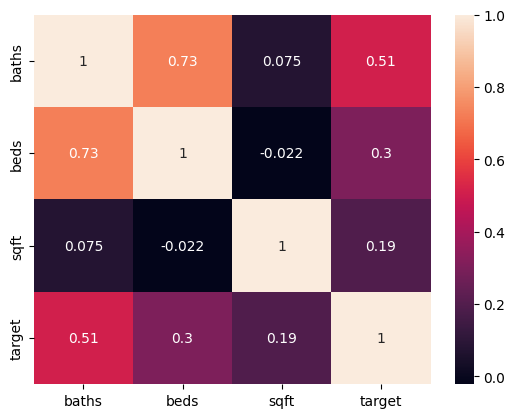

In [41]:
sns.heatmap(corr_matrix, annot=True);

In [42]:
temp_data.to_csv('temp_data_2.csv',index=False)